In [1]:
import os
import time
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, utils
from torchsummary import summary
from sklearn.metrics import accuracy_score, confusion_matrix

from PIL import Image

In [2]:
writer = SummaryWriter('runs/fashion-mnist-1')

## 1. Load CSV files

The csv files can be download from [this link](https://www.kaggle.com/zalando-research/fashionmnist)

In [3]:
data_path = os.path.join("storage", "data", "fashion-mnist")
train_path = os.path.join(data_path, "fashion-mnist_train.csv")
test_path = os.path.join(data_path, "fashion-mnist_test.csv")
print(train_path, test_path)

storage/data/fashion-mnist/fashion-mnist_train.csv storage/data/fashion-mnist/fashion-mnist_test.csv


In [4]:
train_df = pd.read_csv(train_path) 
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_df = pd.read_csv(test_path)
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print(train_df.shape, test_df.shape)
print(train_df.info())
print(test_df.info())

(60000, 785) (10000, 785)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB
None


In [7]:
train_df.iloc[0, 1:].max()

255

In [8]:
train_df['label'].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

In [9]:
test_df['label'].value_counts()

7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
9    1000
1    1000
8    1000
0    1000
Name: label, dtype: int64

## 2. Format into images

Loading all the data in the CSV file is not memory efficient. Also, We cannot understand the data in raw format. Hence, I am going to format this file into images in the following format.
* train/0/xxx.png
* train/1/xxx.png
* train/2/xx.png
* ...

In [24]:
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")
print(train_path, test_path)

storage/data/fashion-mnist/train storage/data/fashion-mnist/test


In [25]:
for path in [train_path, test_path]:
    if not os.path.exists(path):
        os.mkdir(path)

In [26]:
class_labels = train_df['label'].unique().tolist()
print(class_labels)

[2, 9, 6, 0, 3, 4, 5, 8, 7, 1]


In [27]:
for path in [train_path, test_path]:
    for class_label in class_labels:
        class_path = os.path.join(path, str(class_label))
        if not os.path.exists(class_path):
            os.mkdir(class_path)

In [28]:
for row_id, row in tqdm(train_df.iterrows(), total=len(train_df)):
    label = row['label']
    image_path = os.path.join(data_path, "train", str(label), "{}.png".format(row_id))
    pixels = row.iloc[1:].values.astype("uint8")
    pixels = pixels.reshape(28, 28)
    image = Image.fromarray(pixels)
    image.save(image_path)

In [29]:
for row_id, row in tqdm(test_df.iterrows(), total=len(test_df)):
    label = row['label']
    image_path = os.path.join(data_path, "test", str(label), "{}.png".format(row_id))
    pixels = row.iloc[1:].values.astype("uint8")
    pixels = pixels.reshape(28, 28)
    image = Image.fromarray(pixels)
    image.save(image_path)

**Note**: `del dataframe` does not release memory. So restart the notebook and start executimg from the next section after generating images.

## 3. Define dataset

In [10]:
data_path = os.path.join("storage", "data", "fashion-mnist")
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")
print(train_path, test_path)

storage/data/fashion-mnist/train storage/data/fashion-mnist/test


`torchvision.transforms.ToTensor()` squishes the value range from [0, 255] to [0., 1.]

In [11]:
mean = 0.5
sd = 0.5
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((mean, ), (sd, ))
])

We can use `torchvision.datasets.ImageFolder()` to define the dataset instead of writing a dataset class from scratch.

In [12]:
train_set = datasets.ImageFolder(root=train_path, transform=transform)
test_set = datasets.ImageFolder(root=test_path, transform=transform)

## 4. Define dataloader

In [13]:
train_batch_size = 64
test_batch_size = 4

In [14]:
num_cpus = os.cpu_count()
print(num_cpus)

8


In [15]:
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=num_cpus) 
test_loader = DataLoader(test_set, batch_size=4, shuffle=test_batch_size, num_workers=num_cpus)

In [16]:
len_train_loader = len(train_loader)
print(len_train_loader)

938


## 5. Define utilities

In [17]:
label_to_name = {
    "0": "t-shirt",
    "1": "trouser",
    "2": "pullover",
    "3": "dress",
    "4": "coat",
    "5": "sandal", 
    "6": "shirt",
    "7": "sneaker",
    "8": "bag",
    "9": "ankle_boot"
}

In [18]:
name_to_label = {v: k for k, v in label_to_name.items()}
print(name_to_label)

{'t-shirt': '0', 'trouser': '1', 'pullover': '2', 'dress': '3', 'coat': '4', 'sandal': '5', 'shirt': '6', 'sneaker': '7', 'bag': '8', 'ankle_boot': '9'}


In [19]:
def plot_image(image_tensor, title=""):
    """
    Arguments:
    image_tensor -- tensor of Size([1, n_h, n_w]) / Size([3, n_h+4, n_w*m+4])
    """
    # image_tensor.squeeze() -> doesn't work for grids of Size([3, n_h+4, n_c*m+4])
    image_tensor = image_tensor.mean(dim = 0) # Size([28, 28])
    image_tensor = (image_tensor * sd) + mean
    image_tensor = image_tensor * 255 # not necessary
    image_array = image_tensor.numpy()
    plt.figure(figsize=(20, 20))
    plt.imshow(image_array, cmap='Greys')
    plt.title(title)
    return plt.show()

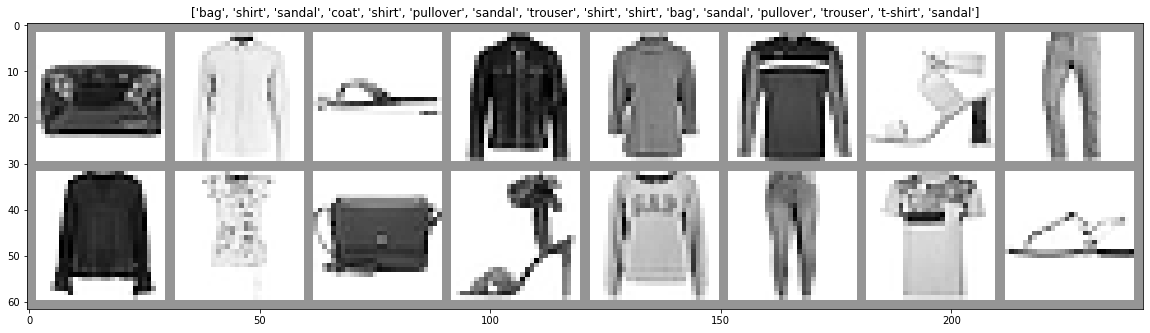

In [20]:
train_iter = iter(train_loader)
X, Y = train_iter.next()
m = min(16, len(train_loader))
image_grid = utils.make_grid(X[:m])
names = [label_to_name[str(label.item())] for label in Y[:m]]
plot_image(image_grid, title=names)

## 6. Define model

In [21]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


The following architecture is modified from the LeNet

In [22]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0) # [m, 6, 24, 24]
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # [m, 6, 12, 12]
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0) # [m, 16, 8, 8]
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # [m, 16, 4, 4]
        self.fc3 = nn.Linear(in_features=16*4*4, out_features=120) # [m, 120]
        self.fc4 = nn.Linear(in_features=120, out_features=84) # [m, 84]
        self.fc5 = nn.Linear(in_features=84, out_features=10) # [m, 10]
        
    def forward(self, X):
        X = self.pool1(F.relu(self.conv1(X)))
        X = self.pool2(F.relu(self.conv2(X)))
        X = X.view(-1, 16*4*4)
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = self.fc5(X) 
        return X

In [23]:
model = Model()
model = nn.DataParallel(model)
model = model.to(device)
print(model)

DataParallel(
  (module): Model(
    (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc3): Linear(in_features=256, out_features=120, bias=True)
    (fc4): Linear(in_features=120, out_features=84, bias=True)
    (fc5): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [24]:
#list(model.parameters())

In [25]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 120]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
             Model-8                   [-1, 10]               0
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


In [26]:
writer.add_graph(model, X)
writer.close()

**Note:** Use `tensorboard --logdir=runs` command in the Terminal to view the TensorBoard

## 7. Set optimizer

In [27]:
lr = 0.001
step_size = len(train_loader) * 4
gamma = 0.95
print(step_size)

3752


In [28]:
criterion = nn.CrossEntropyLoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

## 8. Train model

In [29]:
epochs = 20
print_every_n_epochs = 1

In [ ]:
epoch_losses = []
epoch_lrs = []
iteration_losses = []
iteration_lrs = []

for epoch in tqdm(range(1, epochs+1)):
    epoch_loss = 0
    epoch_lr = 0
    
    for X, Y in tqdm(train_loader, desc="Epoch-{}".format(epoch)):
        X, Y = X.to(device), Y.to(device)
        
        optimizer.zero_grad()
        Y_pred_logits = model(X)
        loss = criterion(Y_pred_logits, Y)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        iteration_losses.append(loss.item())
        iteration_lrs.append(lr_scheduler.get_lr()[0])
        epoch_loss += loss.item()
        epoch_lr += lr_scheduler.get_lr()[0]
        
    epoch_loss /= len(train_loader)
    epoch_lr /= len(train_loader)
    epoch_losses.append(epoch_loss)
    epoch_lrs.append(epoch_lr)
    
    if epoch % print_every_n_epochs == 0:    
        message = "Epoch:{}    Loss:{}    LR:{}".format(epoch, epoch_loss, epoch_lr)
        print(message)
        

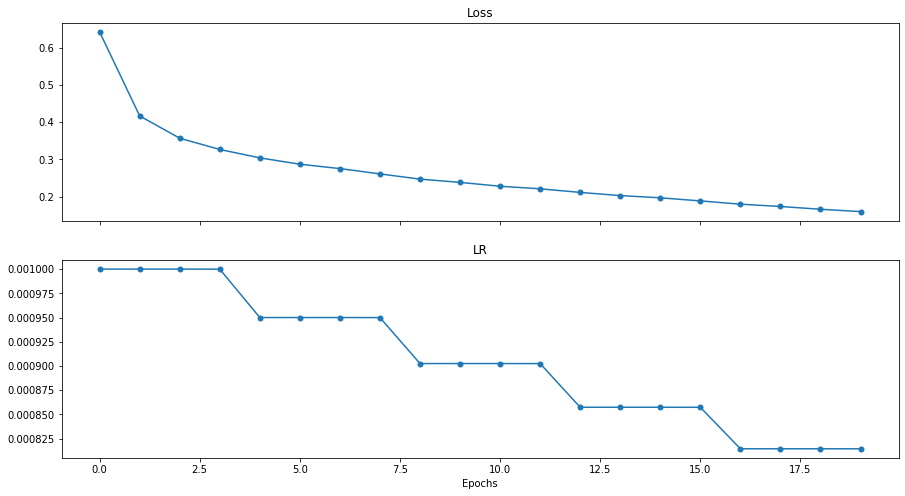

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
ax1.plot(epoch_losses, marker="o", markersize=5)
ax1.set_title("Loss")
ax2.plot(epoch_lrs, marker="o", markersize=5)
ax2.set_title("LR")
plt.xlabel("Epochs")
plt.show()

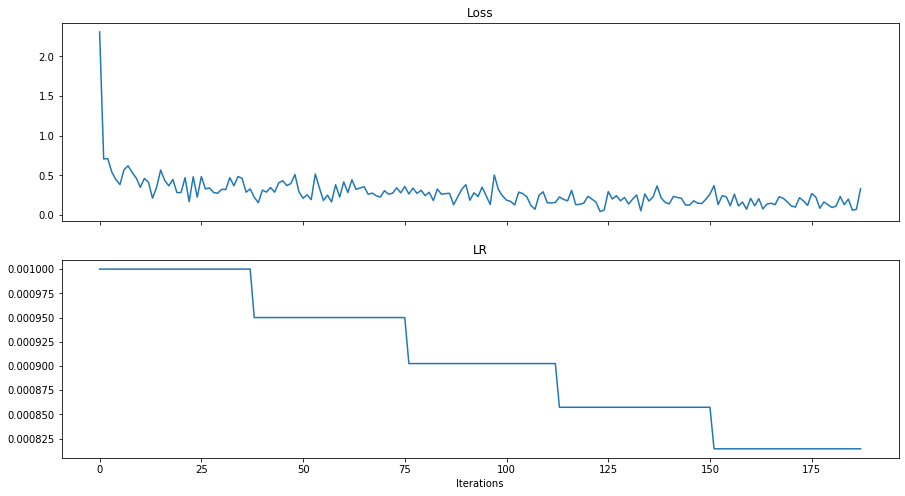

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
ax1.plot(iteration_losses[::100])
ax1.set_title("Loss")
ax2.plot(iteration_lrs[::100])
ax2.set_title("LR")
plt.xlabel("Iterations")
plt.show()

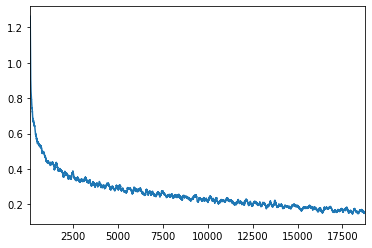

In [33]:
window = 100
pd.Series(iteration_losses).rolling(window=window).mean().iloc[window-1:].plot()
plt.show()

In [34]:
path = os.path.join("storage", "models", "fashion-mnist", "classifier.pth")
torch.save(model.state_dict(), path)

## 9. Test model

In [35]:
path = os.path.join("storage", "models", "fashion-mnist", "classifier.pth")
model = Model()
model = nn.DataParallel(model)
model.load_state_dict(torch.load(path))
#model = model.to("cpu")

<All keys matched successfully>

In [36]:
for p in model.parameters():
    print(p.is_cuda)

True
True
True
True
True
True
True
True
True
True


In [37]:
with torch.no_grad():
    Y_train, Y_pred_train = [], []
    for X_mb, Y_mb in tqdm(train_loader):
        out = model(X_mb)
        _, Y_pred_mb = torch.max(out, 1)
        Y_train.extend(Y_mb.numpy().tolist())
        Y_pred_train.extend(Y_pred_mb.cpu().numpy().tolist())

In [38]:
with torch.no_grad():
    Y_test, Y_pred_test = [], []
    for X_mb, Y_mb in tqdm(test_loader):
        out = model(X_mb)
        _, Y_pred_mb = torch.max(out, 1)
        Y_test.extend(Y_mb.numpy().tolist())
        Y_pred_test.extend(Y_pred_mb.cpu().numpy().tolist())

In [39]:
train_accuracy = accuracy_score(Y_train, Y_pred_train)
test_accuracy = accuracy_score(Y_test, Y_pred_test)
print("Train Accuracy: {}".format(train_accuracy))
print("Test Accuracy: {}".format(test_accuracy))

Train Accuracy: 0.9404166666666667
Test Accuracy: 0.8984


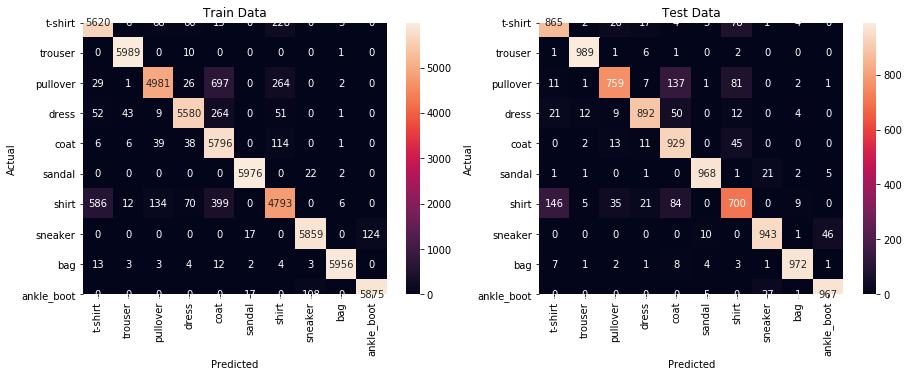

In [40]:
labels = [label_to_name[str(i)] for i in range(10)]
c_mat_train = confusion_matrix(Y_train, Y_pred_train)
c_mat_test = confusion_matrix(Y_test, Y_pred_test)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(c_mat_train, annot=True, fmt='d', ax=ax1, xticklabels=labels, yticklabels=labels)
ax1.set_title('Train Data')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
sns.heatmap(c_mat_test, annot=True, fmt='d', ax=ax2, xticklabels=labels, yticklabels=labels)
ax2.set_title('Test Data')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
plt.show()

In [41]:
def compute_accuracies(c_mat):
    accuracies = c_mat.astype('float') / c_mat.sum(axis=1)
    accuracies = accuracies.diagonal()
    accuracies = {k:v for k, v in zip(labels, accuracies)}
    return accuracies

In [42]:
compute_accuracies(c_mat_train)

{'t-shirt': 0.9366666666666666,
 'trouser': 0.9981666666666666,
 'pullover': 0.8301666666666667,
 'dress': 0.93,
 'coat': 0.966,
 'sandal': 0.996,
 'shirt': 0.7988333333333333,
 'sneaker': 0.9765,
 'bag': 0.9926666666666667,
 'ankle_boot': 0.9791666666666666}

In [43]:
compute_accuracies(c_mat_test)

{'t-shirt': 0.865,
 'trouser': 0.989,
 'pullover': 0.759,
 'dress': 0.892,
 'coat': 0.929,
 'sandal': 0.968,
 'shirt': 0.7,
 'sneaker': 0.943,
 'bag': 0.972,
 'ankle_boot': 0.967}